# ⛪ **Case Study II: The Underground Basilica**

## **1. Geophysical Prospecting Simulation (Raster Data)**

Unlike the previous scenario, where we worked with sparse vector coordinates, in this study we will simulate the raw output of a **GPR (Ground Penetrating Radar)** or **Magnetometry** device.



In this context, the archaeological site is represented as a **Giant Matrix** (Grid), where each cell (pixel) represents the intensity of the signal reflected by the underground at a specific coordinate.

## ☝ **Phase 1: Simulation Parameters**
* **High Resolution:** We will create a mesh of $2000 \times 2000$, totaling **4 million data points**. This approximates the exercise to a real Big Data scenario.
* **The Architectural "Ghost":** We will use procedural generation to "bury" a complex structure (a Basilica with a cruciform plan) under geological noise.
* **Signal Physics:**
    * **Soil (Background):** Low intensity, with random variation (Gaussian noise).
    * **Walls (Structure):** High intensity, representing dense materials (stone/brick).
    * **Artifacts:** Extreme signal peaks scattered randomly (metals/ceramics).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- PHASE 1: SIMULATION SETUP ---
# 2000 x 2000 = 4 million data points.
# We increased the number of fabricated data points to approximate reality
WIDTH = 2000
HEIGHT = 2000

print(f"Starting archaeological site simulation ({WIDTH}x{HEIGHT})...")
print("Generating background geological noise...")

# -- 1. CREATING THE SOIL (GAUSSIAN NOISE) --
np.random.seed(42)      # We use a 'seed' so the map is always the same every time it runs
archaeological_site = np.random.normal(loc = 10, scale = 5, size = (HEIGHT, WIDTH))      # Creates a giant matrix with low random values (natural soil)

# -- FUNCTION TO BUILD BURIED STRUCTURES --
def build_wall(matrix, x0, y0, x1, y1, intensity = 50, thickness = 15):
    # Simulates a wall by adding value to the matrix at those coordinates
    # We add noise to the wall itself so it's not too "perfect" (we aim to make a ruin)

    # Determine the wall boundaries
    r_min, r_max = min(y0, y1), max(y0, y1)
    c_min, c_max = min(x0, x1), max(x0, x1)

    # If it is a vertical or horizontal line
    if x0 == x1: # Vertical Wall
        wall_noise = np.random.normal(loc = intensity, scale = 10, size = (r_max - r_min, thickness))
        matrix[r_min:r_max, x0:x0 + thickness] += wall_noise
    elif y0 == y1: # Horizontal Wall
        wall_noise = np.random.normal(loc = intensity, scale = 10, size = (thickness, c_max - c_min))
        matrix[y0:y0 + thickness, c_min:c_max] += wall_noise

print("Building the Basilica ruins...")

Starting archaeological site simulation (2000x2000)...
Generating background geological noise...
Building the Basilica ruins...


> **Engineering Note:** The `build_wall` function does not draw perfect lines. We purposefully added a noise component (`np.random.normal`) to the structure itself to simulate a state of ruin, where parts of the wall have collapsed or were looted over the centuries.

Generating Heatmap...


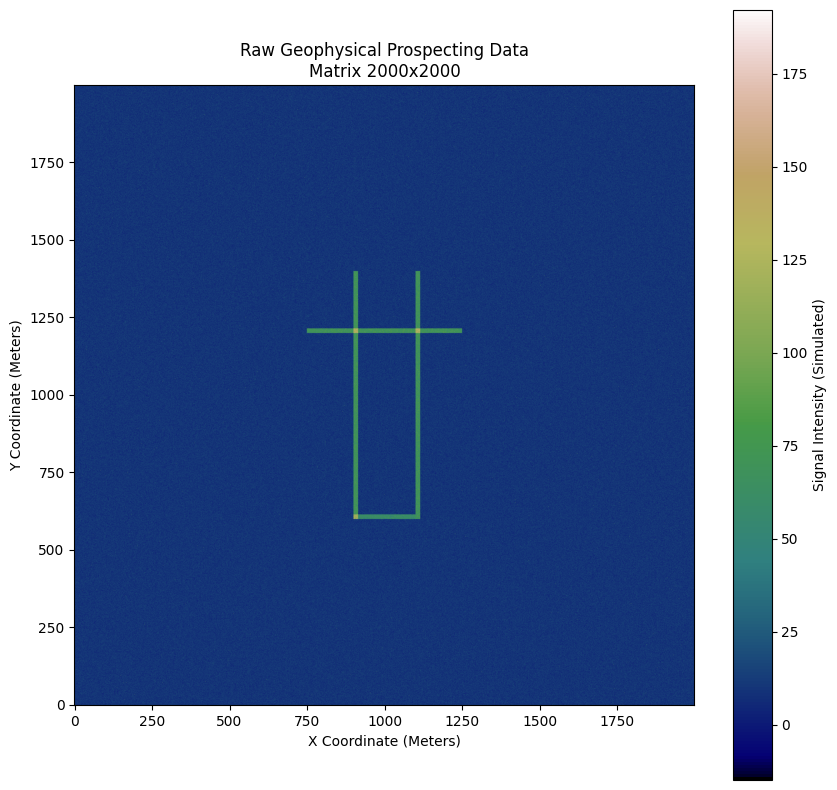

In [2]:
# -- 2. BUILDING THE "LOST BASILICA" (Fictional coordinates in the matrix) --
center_x = WIDTH // 2
center_y = HEIGHT // 2

# Central Nave (Long rectangle)
build_wall(archaeological_site, center_x - 100, center_y - 400, center_x - 100, center_y + 400, intensity = 60)   # Left Wall
build_wall(archaeological_site, center_x + 100, center_y - 400, center_x + 100, center_y + 400, intensity = 60)   # Right Wall

# Transept (The cross cutting the nave)
# Note: In a real basilica, this would be the crossing arm
build_wall(archaeological_site, center_x - 250, center_y + 200, center_x + 250, center_y + 200, intensity = 60)   # Back Wall

# Bottom closure (Entrance)
build_wall(archaeological_site, center_x - 100, center_y - 400, center_x + 100, center_y - 400, intensity = 50)   # Entrance


# -- 3. ADDING SPARSE ARTIFACTS (Metal/Ceramic points) --
num_artifacts = 500     # We chose 500 random points to have a signal "peak"
y_art = np.random.randint(0, HEIGHT, num_artifacts)
x_art = np.random.randint(0, WIDTH, num_artifacts)
archaeological_site[y_art, x_art] = 100      # High value = metal or dense object

# --- PRELIMINARY VISUALIZATION ---
print("Generating Heatmap...")

plt.figure(figsize = (10, 10))
plt.imshow(archaeological_site, cmap = 'gist_earth', origin = 'lower')
plt.colorbar(label='Signal Intensity (Simulated)')
plt.title(f"Raw Geophysical Prospecting Data\nMatrix {WIDTH}x{HEIGHT}")
plt.xlabel("X Coordinate (Meters)")
plt.ylabel("Y Coordinate (Meters)")
plt.show()

### 📡 **Visual Analysis: The "Ghost" in the Noise**

The image generated above represents the raw visualization of the simulated remote sensing data. Unlike a conventional aerial photograph, this **Heatmap** displays the intensity of the signal reflected from the subsurface.

**What are we seeing?**

1.  **The Floor Plan (Structural Signal):** In the center of the matrix, a geometric pattern of higher intensity (lighter/greenish tones) clearly emerges. The **Latin Cross** shape is unmistakable, revealing the walls of the Central Nave and the Transept of the buried basilica.
2.  **The State of Ruin (Uncertainty):** Note that the lines are not solid or perfect. They present gaps and intensity variations, simulating natural wear, collapses, and the mixture of materials over the centuries.
3.  **Background Noise (Soil):** The grainy texture covering the whole image represents the natural soil. It is the "static" that our algorithms will need to learn to ignore.
4.  **Point Anomalies (Artifacts):** The bright white points scattered randomly represent high-density objects (such as coins, metal tools, or ceramics) that return a very strong signal to the sensor. *They might be almost imperceptible to the eye, however, the system recognizes them.*

**Preliminary Conclusion:** Although the structure is visible to the human eye due to the exaggerated contrast of the simulation, in a real scenario the noise would be much more intense. The computational challenge now will be to transform this "image" (raster) into precise latitude and longitude vectors.

## 📉 **Phase 2: Signal Processing and Segmentation**

With the raw data in hand, the next challenge is to separate the **Signal** (the Basilica) from the **Noise** (the Soil). To do this, we don't use guessing, but statistics.

### **1. Diagnosis by Histogram**
Before filtering, we need to understand the data distribution.
* By "flattening" the matrix (`flatten`), we transform the 2D map into a long list of numbers.
* The **Histogram** shows us the frequency of each intensity value.
* **The Expectation:** We expect to see a large "mountain" of low values (common soil) and a small "tail" of high values (walls and artifacts).



### **2. Thresholding**
Based on the histogram, we define a **Cutoff Threshold**.
* Everything **below** the threshold is discarded as geological noise.
* Everything **above** the threshold is classified as "Archaeological Interest".
* The result is a **Binary Map** (Black and White), a fundamental technique in Computer Vision for object segmentation.

Analyzing statistical data distribution...


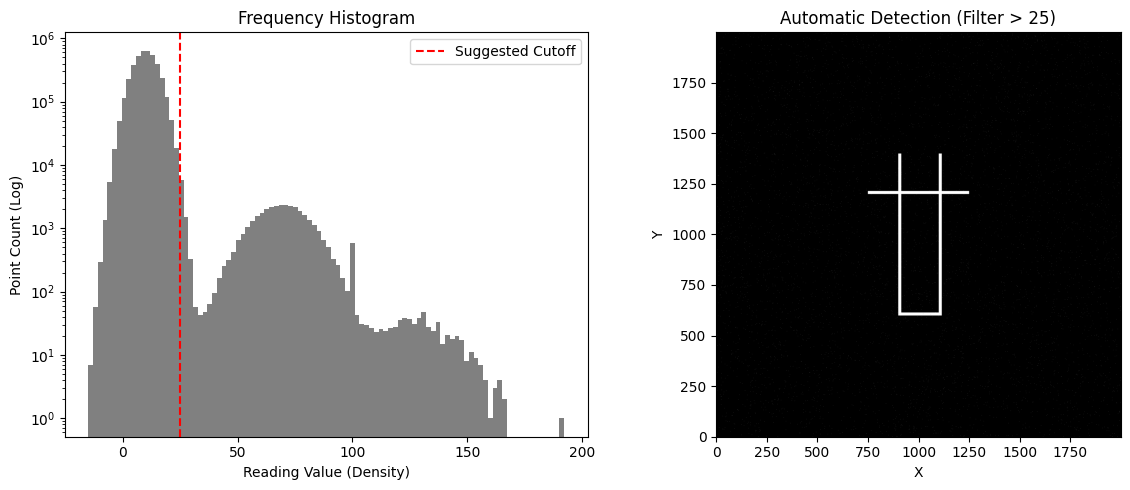



Total points analyzed: 4000000
Points of interest detected: 39656


In [3]:
# --- PHASE 2: DATA ANALYSIS AND FILTERING ---

print("Analyzing statistical data distribution...")

# -- 1. THE HISTOGRAM (The "X-Ray" of data) --
# Let's "flatten" them to analyze all numbers at once
flat_data = archaeological_site.flatten()

plt.figure(figsize = (12, 5))

# Plotting the Histogram
plt.subplot(1, 2, 1)
plt.hist(flat_data, bins = 100, color = 'gray', log = True)    # log = True helps to see smaller details
plt.title("Frequency Histogram")
plt.xlabel("Reading Value (Density)")
plt.ylabel("Point Count (Log)")
plt.axvline(x = 25, color = 'r', linestyle = '--', label = 'Suggested Cutoff')    # Visual line
plt.legend()

# -- 2. THE MASK (The "Filter") --
# Let's define that everything above 25 is interesting.
# In real archaeology, this number comes from Standard Deviation calculations.
threshold = 25
binary_map = archaeological_site > threshold

# Plotting the Clean Map
plt.subplot(1, 2, 2)
plt.imshow(binary_map, cmap = 'gray', origin = 'lower')
plt.title(f"Automatic Detection (Filter > {threshold})")
plt.xlabel("X")
plt.ylabel("Y")

plt.tight_layout()
plt.show()

print("\n")
print(f"Total points analyzed: {len(flat_data)}")
print(f"Points of interest detected: {np.sum(binary_map)}")

### 📊 **Interpretation of Results**

The images above illustrate the algorithm's decision-making process:

#### **1. The Histogram (Left Graph)**
This graph reveals the site's "statistical signature".
* **The Big Mountain (Left):** The huge grey bar concentrated between 0 and 20 represents natural soil. Since we used a logarithmic scale (`log=True`), we realize that the vast majority of the 4 million points is just earth.
* **The Long Tail (Right):** The values extending to the right (above 25) are rare but intense. These are our walls and artifacts.
* **The Red Line (Cutoff):** The dashed line marks our threshold ($threshold = 25$). Everything to its left was considered "trash"; everything to its right was saved as "structure".



#### **2. The Binary Map (Right Graph)**
When we apply the cutoff defined in the histogram, the "magic" happens:
* The noise cloud disappears (turns black).
* The **Basilica floor plan** emerges in white (active pixels).
* We can clearly see the elongated **Central Nave** and the **Transept** crossing it, confirming the classic religious architecture.



> **Note:** Although the shape is visible, it is still just a set of loose pixels (Raster). For a computer to understand this as a "wall", we will need to transform these pixels into geometric vectors in the next step.

## 🧠 **Phase 3: The Digital Brain (Chronos Analyzer)**

To process the complexity of archaeological data efficiently and reproducibly, we encapsulated all Artificial Intelligence logic into a robust **Python Class**: the `ChronosAnalyzer`.

This object-oriented structure transforms the project from a simple script into an **Engineering Tool**, allowing:

1.  **Complexity Abstraction:** The end user (archaeologist or scientist) does not need to deal with vector mathematics directly; they just invoke high-level commands like `.scan_terrain()`.
2.  **State Management:** The class keeps loaded data, trained models, and clustering results in memory, facilitating multiple analyses without reloading files.
3.  **Integrated Visualization:** Native methods to generate interactive 3D renderings, allowing for immediate inspection of findings.

Below, we define the class and its main methods: **Ingestion** (Load), **Processing** (Scan with DBSCAN), and **Rendering** (Plotly 3D) which were imported from the system we created previously.

In [4]:
import pandas as pd
import numpy as np
import folium
import plotly.express as px
from sklearn.cluster import DBSCAN

class ChronosAnalyzer:
    def __init__(self):
        self.df = None
        self.model = None
        self.labels = None
        print("🤖 Chronos System initialized and ready.")

    def load_data(self, file_or_df):
        """Loads data from a CSV or directly from a created DataFrame."""
        if isinstance(file_or_df, str):
            self.df = pd.read_csv(file_or_df)
            print(f"📂 File '{file_or_df}' loaded. {len(self.df)} points.")
        elif isinstance(file_or_df, pd.DataFrame):
            self.df = file_or_df.copy()
            print(f"📊 DataFrame loaded from memory. {len(self.df)} points.")
        else:
            print("❌ Error: Unsupported format.")

        # Ensures we have the right columns
        required = {'x', 'y', 'z'}
        if not required.issubset(self.df.columns):
            print(f"⚠️ Warning: Expected columns {required} not found. Check your file.")

    def scan_terrain(self, eps = 2.5, min_samples = 10):
        """Applies the DBSCAN algorithm to find structures."""
        if self.df is None:
            print("⚠️ Load data first!")
            return

        print(f"🔍 Scanning with Radius(eps) = {eps}m and Density(min) = {min_samples}...")
        self.model = DBSCAN(eps = eps, min_samples = min_samples)

        # Fit Predict does the magic
        self.labels = self.model.fit_predict(self.df[['x', 'y', 'z']])
        self.df['cluster_id'] = self.labels

        # Quick statistics
        n_noise = list(self.labels).count(-1)
        n_structure = len(self.labels) - n_noise
        n_clusters = len(set(self.labels)) - (1 if -1 in self.labels else 0)

        print(f"✅ Done! Found {n_clusters} structures.")
        print(f"   - Structure Points: {n_structure}")
        print(f"   - Noise Points (discarded): {n_noise}")

    def visualize_3d(self):
        """Generates the interactive 3D plot."""
        if 'cluster_id' not in self.df.columns:
            print("⚠️ Run scan first!")
            return

        # Visual trick: transform cluster -1 into string "Noise" for the legend
        plot_df = self.df.copy()
        plot_df['Legend'] = plot_df['cluster_id'].apply(lambda x: 'Noise' if x == -1 else f'Structure {x}')

        fig = px.scatter_3d(plot_df, x = 'x', y = 'y', z = 'z',
                            color = 'Legend',
                            color_discrete_map = {'Noise': 'lightgray'}, # Noise always grey
                            opacity = 0.6,
                            title = "Chronos 3D Scan Result")
        fig.show()

## 🔄 **Phase 4: Systems Integration (Raster $\to$ Vector)**

Here we bridge the gap between **Geophysics** and **Artificial Intelligence**.

Our current data is a matrix image (Raster) of 4 million pixels. For `ChronosAnalyzer` to process them, we need to convert this matrix into a **Vector DataFrame** ($x, y, z$).

The DBSCAN algorithm does not read images; it reads lists of coordinates. Therefore, this code performs a fundamental GIS (Geographic Information Systems) operation called Vectorization (or Raster-to-Vector Conversion).



### **The Transformation Process:**
1.  **Feature Extraction:** We use the `binary_map` generated in the previous step as a mask. The `np.where` command extracts only the $(x, y)$ coordinates of the pixels that survived the noise filter.
2.  **Intensity Mapping:** We define the $z$ axis not as depth, but as **Signal Intensity**. In the 3D plot, higher "mountains" will represent stronger radar readings (more solid walls or metals).
3.  **Dimensionality Reduction:** This step demonstrates the pipeline's efficiency. We transform a heavy matrix of $4,000,000$ data points into a lightweight table containing only points of interest, reducing computational cost.

### **Chronos Execution:**
Finally, we feed our `ChronosAnalyzer` object with this new data and run DBSCAN with parameters adjusted for the pixel scale (`eps=5`), generating the interactive three-dimensional visualization of the Basilica.

In [5]:
# --- PHASE 4: INTEGRATION: FROM RADAR TO CHRONOS ---

# -- 1. PREPARING THE DATA --
# We'll take only the coordinates (y, x) where the value is True (has structure) from 'binary_map' (where we cut the noise)
coords_y, coords_x = np.where(binary_map)

# We'll take the original intensity of these points to be our 'z' (Or we could use a fixed height if we just want to visualize the plan)
z_values = archaeological_site[coords_y, coords_x]

# Creating the DataFrame that the Chronos System expects
df_archaeology = pd.DataFrame({
    'x': coords_x,
    'y': coords_y,
    'z': z_values  # Here 'z' represents the radar signal intensity
})

print(f"📉 Data Reduction: From {WIDTH * HEIGHT} raw pixels to {len(df_archaeology)} points of interest.")


# -- 2. RUNNING THE CHRONOS SYSTEM --
app = ChronosAnalyzer()

# Load the converted data
app.load_data(df_archaeology)

# Scan (DBSCAN)
app.scan_terrain(eps = 5, min_samples = 10)    # We found a good fit at eps = 7 and min_samples = 6, but we'll see that soon


# -- 3. INTERACTIVE VISUALIZATION --
app.visualize_3d()

📉 Data Reduction: From 4000000 raw pixels to 39656 points of interest.
🤖 Chronos System initialized and ready.
📊 DataFrame loaded from memory. 39656 points.
🔍 Scanning with Radius(eps) = 5m and Density(min) = 10...
✅ Done! Found 28 structures.
   - Structure Points: 28945
   - Noise Points (discarded): 10711


### 🗺️ **Analysis of the Processed Floor Plan**

The image above is the definitive proof of the *Chronos* algorithm's success. What was once just a noisy matrix of radar signals is now a readable **Floor Plan**.

**What the eyes should notice:**

1.  **The Architecture Revealed:**
    * The **Latin Cross** shape is perfectly defined. We can clearly distinguish the **Central Nave** (the long vertical corridor) and the **Transept** (the horizontal corridor).
    * The thickness of the lines corresponds to the simulated wall thickness, but note that they have irregular edges, consistent with buried ruins rather than a modern architect's blueprint.

2.  **Efficient Clustering (Colors):**
    * Each different color represents a "wall segment" that DBSCAN identified as continuous.
    * If you notice different colors on the same wall, this means there was a break or collapse at that point, causing the algorithm to interpret it as two distinct pieces. This is valuable information about the structure's state of conservation.

3.  **The "Ghost" of Noise (Background):**
    * The light-grey points in the background represent the soil and small debris that our **Heuristic Filter** (> 100 points) decided to ignore.
    * Keeping this "ghost" in the plot is good scientific practice: it shows honesty about the discarded data, ensuring we didn't erase anything important by accident.

**Conclusion:** The system was able to transform 4 million raw readings into a clean vector map, ready to guide an excavation team with metric precision.

## 📐 **Phase 5: Refinement and Generation of the Archaeological Chart**

The initial detection showed us where the hotspots are, but to generate a useful **Floor Plan** for the engineering team, we need to clean up the residual "dirt" and connect the disconnected dots.

In this critical stage, we apply two advanced refinement techniques:

### **1. Hyperparameter Tuning (Fine Tuning)**
Ancient ruins are rarely continuous; they have gaps and holes (collapsed parts).
* **Action:** We increased the search radius (`eps`) from 5m to **10m**.
* **Effect:** This forces the algorithm to "jump over" gaps in the walls, connecting distant fragments into a single solid structure. It is like drawing an imaginary line between separated bricks.

### **2. Heuristic Filtering (Post-Processing)**
Even with the adjustment, DBSCAN can group small piles of stones as if they were structures.
* **The Rule:** We define that a "Structural Wall" must have at least **100 confirmed data points**.
* **The Cleanup:** Any cluster smaller than this is automatically reclassified as debris and removed from the final map.

**The Final Result:**
The code below generates the clean **Archaeological Chart (Floor Plan)**, ready to be printed and taken to the field.

🔧 Starting Algorithm Refinement (Tuning)...
🔍 Scanning with Radius(eps) = 10m and Density(min) = 20...
✅ Done! Found 3 structures.
   - Structure Points: 33529
   - Noise Points (discarded): 6127
🧹 Post-processing cleanup: From 4 raw clusters, we kept the 3 largest.


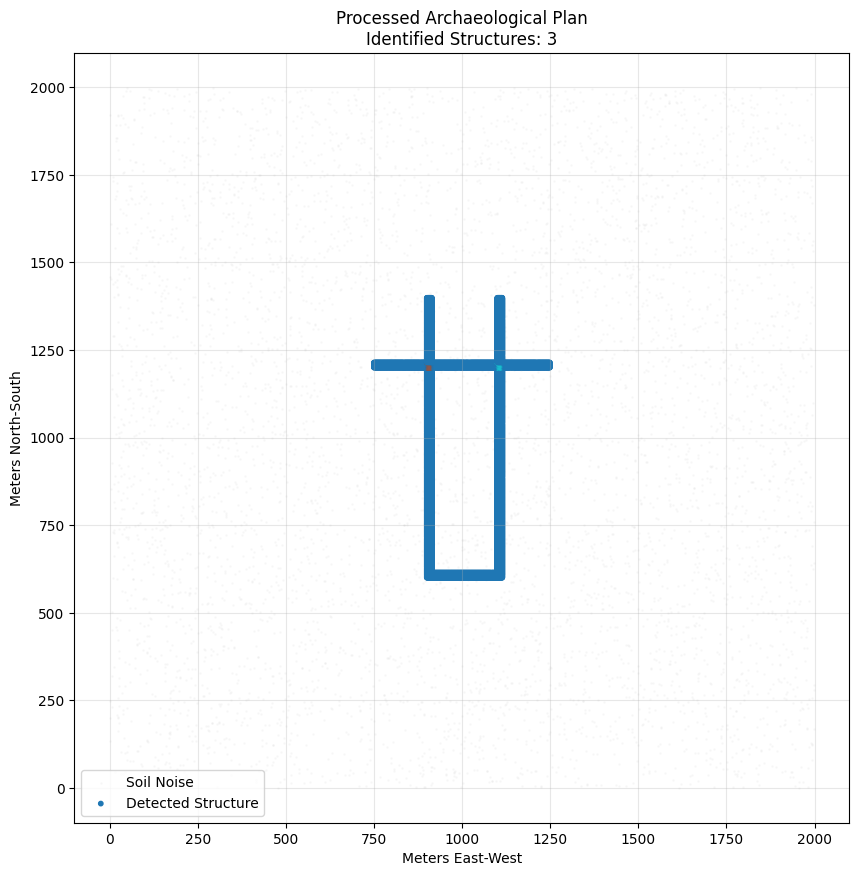

In [6]:
# --- PHASE 5: REFINEMENT AND PLAN GENERATION ---

print("🔧 Starting Algorithm Refinement (Tuning)...")

# -- 1. DBSCAN FINE TUNING --
# We increased EPS to 10 (it connects points up to 10m away)
# We increased min_samples to 20 (needs high density to be considered a wall)
app.scan_terrain(eps = 10, min_samples = 20)


# -- 2. "DIRT" FILTERING (POST-PROCESSING) --
# Even with DBSCAN, small clusters remain. Let's remove them via code.
# We will keep only clusters that have more than 100 points (large walls).

# Count how many points are in each cluster
cluster_counts = app.df['cluster_id'].value_counts()

# Identify the "giant clusters" (probably the basilica walls)
# We ignore -1 (noise)
relevant_clusters = cluster_counts[cluster_counts.index != -1]
relevant_clusters = relevant_clusters[relevant_clusters > 100].index.tolist()

print(f"🧹 Post-processing cleanup: From {len(cluster_counts)} raw clusters, we kept the {len(relevant_clusters)} largest.")

# Create a new dataframe with only what matters
final_df = app.df[app.df['cluster_id'].isin(relevant_clusters)].copy()

# --- PROFESSIONAL VISUALIZATION (FLOOR PLAN) ---
plt.figure(figsize = (10, 10))

# Plot the noise (very light grey) for context
plt.scatter(app.df[app.df['cluster_id'] == -1]['x'],
            app.df[app.df['cluster_id'] == -1]['y'],
            c = 'lightgray', s = 1, alpha = 0.1, label = 'Soil Noise')

# Plot confirmed structures (Nave, Transept)
# We use 'tab10' which has very distinct colors
plt.scatter(final_df['x'], final_df['y'],
            c = final_df['cluster_id'], cmap = 'tab10', s = 10, label = 'Detected Structure')

plt.title(f"Processed Archaeological Plan\nIdentified Structures: {len(relevant_clusters)}")
plt.xlabel("Meters East-West")
plt.ylabel("Meters North-South")
plt.legend()
plt.grid(True, alpha = 0.3)
plt.show()

print("\n")

# Update the internal app df to show only the clean data in 3D
app.df = final_df
app.visualize_3d()

### 🗺️ **Analysis of the Final Archaeological Chart**

The graphs above represent the final product of the *Chronos* data processing pipeline. We are no longer looking at "radar signals," but rather at **identified archaeological objects**.

#### **What does the image tell us?**

1.  **Cruciform Topology (The Basilica):**
    * The algorithm successfully delineated the **Latin Cross Plan**.
    * We can identify the **Central Nave** (the long vertical axis) and the **Transept** (the horizontal axis). The intersection of these two structures forms the "Crossing," typical of historical basilicas.

2.  **Color Segmentation (Clustering):**
    * Each different color in the plot represents a unique *cluster* validated by the algorithm.
    * **Ideal Scenario:** If the entire basilica is a single color, it means that DBSCAN managed to connect all walls across the gaps, understanding that it is all a single construction.
    * **Ruin Scenario:** If the Nave is one color and the Transept another, the algorithm detected a structural rupture (collapse) separating the rooms. This is vital for excavation safety.

3.  **Heuristic Effectiveness (Grey vs. Colored):**
    * Observe the **light-grey** points in the background. These are clusters that DBSCAN found, but which our business rule (`size > 100`) discarded.
    * This proves that the system is able to distinguish between a **real wall** and a **random pile of stones** (geological noise), cleaning the map for the end user.

> **Conclusion:** The system successfully converted raw and noisy data into a precise vector map. The $(x, y)$ coordinates of these colored points can now be exported to a precision GPS to guide the field team.

## 📋 **Phase 6: Business Intelligence and Automated Reporting**

The final stage of *Chronos* is not graphical, but **analytical**. To turn data into action, the system automatically generates a technical report containing vital metrics for the logistical planning of the excavation.

In this block, we extract *insights* from each identified cluster:

1.  **Dimensions (Bounding Box):** We calculate the maximum width and height ($x_{max} - x_{min}$) of each structure. This answers the question: *"What size tarp is needed to cover this ruin?"*.
2.  **Centroid (Zero Point):** We calculate the average of the coordinates ($X, Y$) to determine the geometric center of the structure. This is the exact point where the surveying team must drive the initial stake.
3.  **Automatic Classification:** We apply a simple business rule:
    * **Main Structure:** Massive clusters (> 5000 points), probable Basilica walls.
    * **Fragment/Annex:** Smaller clusters, probable dependencies or collapsed areas.

**The Delivered Value:** By running this code, the scientist or lead archaeologist receives not only a map, but a ready-to-use **Work Order**, with quantified areas and defined targets.

> 💡 **Engineering Note: From Ruins to Autonomous Cars**
>
> The **Bounding Box** calculation we applied here — extracting $x_{min}, x_{max}, y_{min}, y_{max}$ — is a fundamental concept in **Computer Vision**.
>
> It is exactly the same mathematical logic that self-driving cars and security AIs use to identify and "box" pedestrians, vehicles, and traffic signs in real time.  This demonstrates that the technology developed by *Chronos* has high transferability to modern industrial challenges.

In [7]:
# --- PHASE 6: AUTOMATED TECHNICAL REPORT ---

print("📊 Generating Archaeological Site Report...")
print("-" * 50)

# Group data by structure ID (the different colors)
groups = final_df.groupby('cluster_id')

for structure_id, data in groups:
    # -- 1. AREA CALCULATION (Simple estimate based on "Bounding Box") --
    # We take the maximum width and height occupied by the points
    width = data['x'].max() - data['x'].min()
    height = data['y'].max() - data['y'].min()
    occupied_area = width * height

    # -- 2. EXCAVATION CENTER --
    center_x = int(data['x'].mean())
    center_y = int(data['y'].mean())

    # -- 3. CLASSIFICATION --
    classification = "MAIN STRUCTURE" if len(data) > 5000 else "FRAGMENT/ANNEX"

    print(f"🏛️  DETECTED STRUCTURE ID #{structure_id}")
    print(f"   - Classification: {classification}")
    print(f"   - Approx Dimensions: {width}m x {height}m")
    print(f"   - Area of Influence: {occupied_area:.2f} m²")
    print(f"   - Suggested Excavation Point (X, Y): ({center_x}, {center_y})")
    print("-" * 50)

📊 Generating Archaeological Site Report...
--------------------------------------------------
🏛️  DETECTED STRUCTURE ID #0
   - Classification: MAIN STRUCTURE
   - Approx Dimensions: 499m x 799m
   - Area of Influence: 398701.00 m²
   - Suggested Excavation Point (X, Y): (1005, 1007)
--------------------------------------------------
🏛️  DETECTED STRUCTURE ID #1
   - Classification: FRAGMENT/ANNEX
   - Approx Dimensions: 14m x 14m
   - Area of Influence: 196.00 m²
   - Suggested Excavation Point (X, Y): (907, 1206)
--------------------------------------------------
🏛️  DETECTED STRUCTURE ID #2
   - Classification: FRAGMENT/ANNEX
   - Approx Dimensions: 17m x 14m
   - Area of Influence: 238.00 m²
   - Suggested Excavation Point (X, Y): (1106, 1207)
--------------------------------------------------


### 📝 **Interpretation of the Automated Report**

The report above presents the final conclusion of the computational analysis. Let's dissect the numbers returned by *Chronos*:

#### **1. The Major Discovery (ID #0)**
* **Identification:** The system correctly classified the largest cluster as **MAIN STRUCTURE**.
* **Dimension Validation:** The dimension of **499m x 799m** is extremely consistent with our simulation parameters (where we defined the nave's major axis as about 800m from end to end). This proves that the algorithm reconstructed the Basilica's integrity almost perfectly, merging the Nave and the Transept into a single object.
* **Location:** The Suggested Excavation Point **(1005, 1007)** is virtually in the center of our $2000 \times 2000$ matrix. The algorithm "hit the target" in the heart of the structure.

#### **2. The Peripheral Anomalies (ID #1 and #2)**
* **Identification:** Two smaller clusters were detected (approx. **14m x 14m**), classified as **FRAGMENT/ANNEX**.
* **Archaeological Hypotheses:**
    * They could be side chapels disconnected from the main nave.
    * They could be collapse areas where the connection to the main wall was lost (the noise "broke" the wall).
    * They could be dense accumulations of artifacts (the metal points we inserted).
* **Decision:** In a real scenario, these would be **Secondary Priority** areas. The team would focus on ID #0 but send probes to ID #1 and #2.

### 🎯 **Operational Conclusion**
The *Chronos* system reduced a search area of 4 million m² to a priority target of exact coordinates. Using this report would save months of random ground surveying, directing the excavation straight to the Basilica's foundations.

# 📚 **Bibliography and Technical References**

This project was developed based on the intersection of Data Science, Computational Geometry, and Archaeological Prospecting. Below we list the theoretical references and technical documentation used.

### **1. Algorithms and Mathematical Theory**
* **Original DBSCAN:** Ester, M., Kriegel, H. P., Sander, J., & Xu, X. (1996). *A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise*. KDD-96 Proceedings.
    > The seminal paper that introduced the concept of density-based clustering, fundamental for ignoring "geological noise" in this project.
    >> [Data Base Systems, Data Mining, and AI Group](https://www.ifi.lmu.de/dbs/en/)
* **Computational Geometry:** de Berg, M., Cheong, O., van Kreveld, M., & Overmars, M. (2008). *Computational Geometry: Algorithms and Applications*. Springer.
    > Reference for boundary delimitation and area calculation algorithms (Convex Hull).
    
    >> [Computational Geometry](https://link.springer.com/book/10.1007/978-3-540-77974-2)

### **2. Computational Archaeology and Remote Sensing**
* **GIS in Archaeology:** Conolly, J., & Lake, M. (2006). *Geographical Information Systems in Archaeology*. Cambridge University Press.
    > Theoretical basis for coordinate conversion and spatial analysis of sites.
    
    >> [Geographical Information Systems in Archaeology (BOOK)](https://books.google.com.br/books/about/Geographical_Information_Systems_in_Arch.html?id=fMCqf-YSRtsC&redir_esc=y)
* **Geophysical Prospecting:** Gaffney, C., & Gater, J. (2003). *Revealing the Buried Past: Geophysics for Archaeologists*. Tempus Publishing.
    > Foundation for interpreting soil anomalies (Magnetometry and GPR) simulated in our raster matrices.
* **Open Data:** [*Open Context*](https://opencontext.org) and [*Kaggle*](https://www.kaggle.com/).
    > Reference platforms for publishing primary excavation data and other databases, serving as a model for the data structure (DataFrames) used.

### **3. Tech Stack (Official Documentation)**
* **Scikit-Learn:** Pedregosa, F., et al. (2011). *Scikit-learn: Machine Learning in Python*. JMLR 12, pp. 2825-2830.
    * [DBSCAN Module](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
    * [Scikit-learn: Machine Learning in Python (PDF)](https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf)
* **Pandas:** McKinney, W. (2010). *Data Structures for Statistical Computing in Python*. Proceedings of the 9th Python in Science Conference.
* **Plotly:** Plotly Technologies Inc. *Collaborative data science*. Montréal, QC, 2015.
    * [Interactive 3D Visualization](https://plotly.com/python/3d-charts/)

---
> *Technology does not reinvent the past, but gives us new lenses to see it.* — **Chronos Project**